In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import random

from pybedtools import BedTool
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os
import seaborn as sns

In [2]:
def extract_binding_sequences(bed_file, fasta_file, output_fasta):

    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    bed = BedTool(bed_file)

    records = []

    for i, interval in enumerate(bed):
        chrom = interval.chrom
        start = int(interval.start)
        end = int(interval.end)

        seq = genome[chrom].seq[start:end] 
        record = SeqRecord(seq, id=f"{chrom}:{start}-{end}", description="")
        records.append(record.upper())

    SeqIO.write(records, output_fasta, "fasta")
 
def extract_binding_sequences_center(bed_file, fasta_file, output_fasta, length):

    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    bed = BedTool(bed_file)

    records = []

    for i, interval in enumerate(bed):
        chrom = interval.chrom
        start = int(interval.start)
        end = int(interval.end)
        center = (start + end) // 2
        center_start = center - (length//2)
        center_end = center + (length//2)

        seq = genome[chrom].seq[center_start:center_end] 
        record = SeqRecord(seq, id=f"{chrom}:{center_start}-{center_end}", description="")
        records.append(record.upper())

    SeqIO.write(records, output_fasta, "fasta")
 

In [3]:
extract_binding_sequences_center("jun_np_chr22_GRCh38.bed", "chr22_GRCh28.fasta", "jun_np_chr22.fasta", 100)

Ejercicio 5.2: 

a) genere los 3 sets de secuencias negativas. Para el conjunto N3 (seceencias
del genoma que NO unen el FT) puede en primer lugar tomar secuencias (de largo fijo)
adyacentes y/o a “n” nt de distancia del sitio de union del FP. Alternativamente puede
seleccionar secuencias del Chr22 al azar (o puede probar ambas).

b) escriba el codigo para a partir del fasta con las secuencias de ADN ls convierta en un tensor
de pytorch de dimension Nseqs, 4, largo Seq

c) integre al codigo “b” la opciòn de hacer “0” padding y/o recorte las secuencias a un largo fijo.

d) Escriba el codigo que genera ademas el tensor que posee la clasificaciòn real de la
secuencia en si une (y_true=1) (o no, y_true=0) el FT. Usualmente a este tensor se lo llama
y_true.

In [3]:
def one_hot_encoding(sequence):

    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq_len = len(sequence)
    encoding = np.zeros((4, seq_len), dtype=np.float32)

    indices = np.array([mapping.get(base, 4) for base in sequence])

    valid_indices = indices[indices < 4]  # Exclude 'N' positions
    encoding[valid_indices, np.arange(seq_len)[indices < 4]] = 1.0

    n_positions = (indices == 4)
    encoding[:, n_positions] = 0.25

    return torch.Tensor(encoding)


def dinucleotide_shuffle(sequence):
    
    dinucleotides = [sequence[i:i+2] for i in range(0, len(sequence), 2)]
    np.random.shuffle(dinucleotides)
    shuffled_sequence_str = ''.join(dinucleotides)
    
    return shuffled_sequence_str

def padding(one_hot_sequence, len = 100):

    L = one_hot_sequence.shape[1]
    pad_total = len - L
    pad_left = pad_total // 2
    pad_right = pad_total - pad_left
        
    pad_tensor = torch.nn.functional.pad(one_hot_sequence, (pad_left, pad_right), mode='constant', value=0)
   
    return pad_tensor

def generate_dna_sequences(num_sequences, sequence_length=100, seed=None):
    if seed is not None:
        random.seed(seed)

    bases = ['A', 'T', 'C', 'G']
    
    sequences = []

    for i in range(num_sequences):
        
        random_sequence = [random.choice(bases) for _ in range(sequence_length)]
        random_sequence = ''.join(random_sequence)
        sequences.append(random_sequence)
    return sequences

def mutation(one_hot_sequence, n_mutations = 50):
    nucleotide_map = ['A', 'C', 'G', 'T']
    choices = {nt: [x for x in nucleotide_map if x != nt] for nt in nucleotide_map}
    seq_len = len(one_hot_sequence)

    mutation_indices = np.random.choice(seq_len, size=n_mutations, replace=False)

    mutated_sequence = ''.join([
        np.random.choice(choices[nt]) if i in mutation_indices else nt
        for i, nt in enumerate(one_hot_sequence)
    ])

    return mutated_sequence

def extract_random_sequences(fasta_file, chrom="chr22", seq_len=100, n_seqs=561):
    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    chrom_seq = genome[chrom].seq
    chrom_len = len(chrom_seq)

    sequences = []
    for _ in range(n_seqs):
        start = random.randint(0, chrom_len - seq_len)
        end = start + seq_len
        seq = chrom_seq[start:end]
        if "N" not in str(seq):
            sequences.append(str(seq).upper())  # Convertir a string y pasar a mayúsculas

    return sequences


In [235]:
sites = list(SeqIO.parse("jun_np_chr22.fasta", "fasta"))
sites = [str(seq_record.seq) for seq_record in sites]
#tn = [dinucleotide_shuffle(site) for site in sites]
tn = generate_dna_sequences(len(sites))
#tn = [mutation(site) for site in sites]
#tn = extract_random_sequences("chr22_GRCh28.fasta")

sites_one_hot = torch.stack([padding(one_hot_encoding(x)).float() for x in sites])
tn_one_hot = torch.stack([padding(one_hot_encoding(y)).float() for y in tn])

y_true = np.array([1 for i in range(sites_one_hot.shape[0])] + [0 for i in range(tn_one_hot.shape[0])])
X = np.vstack([sites_one_hot, tn_one_hot])

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size = 0.15, stratify=y_true)

y_train = torch.tensor(y_train, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

In [9]:
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super(DNA_CNN, self).__init__()
#         c=16
#         k=5
#         nt_len = 100
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=c, kernel_size=k)
#         # Fully connected layer: Maps to the output
#         # Calculate the output size after the convolutional layer
#         conv_output_len = nt_len - k + 1  # longitud de la secuencia tras la convolución
#         self.fc1 = nn.Linear(c * conv_output_len, 1)
    
#     def forward(self, x):
#         # Apply convolution, followed by ReLU activation
#         x = F.relu(self.conv1(x))
#         # Flatten the output from the convolutional layer
#         x = x.view(x.size(0), -1) # Reshape to (batch_size,flattened_features)
#         # Fully connected layer and output
#         x = self.fc1(x)
#         x = torch.sigmoid(x) # Apply sigmoid for binary classification
#         return x.squeeze(1)
class DNA_CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        c = 16
        k = 5
        nt_len = 100
        conv_output_len = nt_len - k + 1

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=c, kernel_size=k),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  
            #nn.Dropout(p=0.5),  # Dropout with 50% probability
            nn.Linear(c * (conv_output_len), 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)

In [4]:
def train(network, optimizer, 
          criterion, 
          train_loader = None):
    
    network.train()
    batch_size = train_loader.batch_size
    total_loss = 0

    for batch_i, (data, target) in enumerate(train_loader):

        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def test(network, criterion, valid_loader):
    
    network.eval()
    total_val_loss = 0
    batch_size = valid_loader.batch_size
    
    with torch.inference_mode():
        for batch_i, (data, target) in enumerate(valid_loader):
            output = network(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    return avg_val_loss


In [5]:
def eval_model(network, data_loader):

    network.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for data, target in data_loader:
            output = network(data)
            predictions = (output > 0.5).float()  # Umbral para clasificación binaria
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calcular métricas
    accuracy = np.mean(y_true == y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))  # Verdaderos positivos
    tn = np.sum((y_true == 0) & (y_pred == 0))  # Verdaderos negativos
    fp = np.sum((y_true == 0) & (y_pred == 1))  # Falsos positivos
    fn = np.sum((y_true == 1) & (y_pred == 0))  # Falsos negativos

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilidad (Recall)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Especificidad
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0    # Precisión
    auc = roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else 0

    network.train()
    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "auc": auc
    }


Epoch 0
Performance:
accuracy: 0.6864
sensitivity: 0.4524
specificity: 0.9176
precision: 0.8444
auc: 0.6850

Epoch 10
Performance:
accuracy: 0.8462
sensitivity: 0.8690
specificity: 0.8235
precision: 0.8295
auc: 0.8463

Epoch 50
Performance:
accuracy: 0.9349
sensitivity: 0.9405
specificity: 0.9294
precision: 0.9294
auc: 0.9349


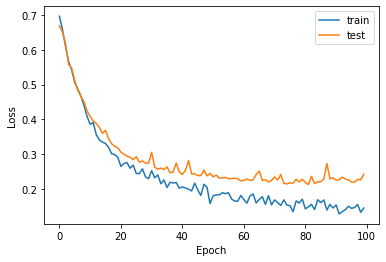

In [240]:
my_nn = DNA_CNN1()
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optimizer = optim.Adam(my_nn.parameters(), lr=0.001)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

dataset_val = TensorDataset(X_test, y_test)
dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)

losses = []
losses_val = []

epochs = 100 # Number of epochs

for epoch in range(epochs):
    
    avg_train_loss = train(my_nn, optimizer, criterion, dataloader)
    avg_val_loss = test(my_nn, criterion, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)
    
    if epoch in [0, 10, 50, 100]:
        metrics = eval_model(my_nn, dataloader_val)
        print(f"\nEpoch {epoch}")
        print("Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


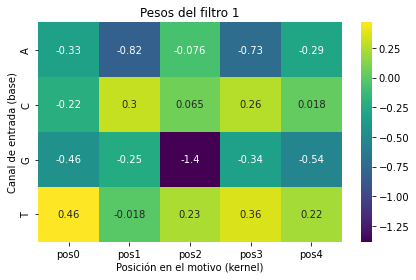

In [241]:
conv_weights = my_nn.features[0].weight.data.cpu().numpy()  # shape: (out_channels, in_channels, kernel_size)

filter_index = 1
weight_matrix = conv_weights[filter_index]  # shape: (4, 5), (in_channels, kernel_size)

plt.figure(figsize=(6, 4))
sns.heatmap(weight_matrix, annot=True, cmap="viridis", xticklabels=[f"pos{i}" for i in range(weight_matrix.shape[1])],
            yticklabels=["A", "C", "G", "T"])
plt.title(f"Pesos del filtro {filter_index}")
plt.xlabel("Posición en el motivo (kernel)")
plt.ylabel("Canal de entrada (base)")
plt.tight_layout()
plt.show()

# TN: secuencias random 

In [253]:
#tn = extract_random_sequences("chr22_GRCh28.fasta")
tn = generate_dna_sequences(len(sites))
tn_one_hot = torch.stack([padding(one_hot_encoding(y)).float() for y in tn])

y_true = np.array([1 for i in range(sites_one_hot.shape[0])] + [0 for i in range(tn_one_hot.shape[0])])
X = np.vstack([sites_one_hot, tn_one_hot])

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size = 0.15, stratify=y_true)

y_train = torch.tensor(y_train, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)


Epoch 1
Performance:
accuracy: 0.4911
sensitivity: 0.9167
specificity: 0.0706
precision: 0.4936
auc: 0.4936

Epoch 10
Performance:
accuracy: 0.7633
sensitivity: 0.6667
specificity: 0.8588
precision: 0.8235
auc: 0.7627

Epoch 50
Performance:
accuracy: 0.8225
sensitivity: 0.8214
specificity: 0.8235
precision: 0.8214
auc: 0.8225

Epoch 100
Performance:
accuracy: 0.8343
sensitivity: 0.8333
specificity: 0.8353
precision: 0.8333
auc: 0.8343


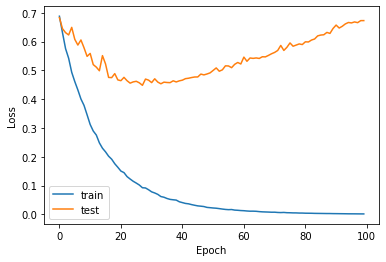

In [254]:
my_nn = DNA_CNN1()
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optimizer = optim.Adam(my_nn.parameters(), lr=0.001)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

dataset_val = TensorDataset(X_test, y_test)
dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)

losses = []
losses_val = []

epochs = 100 # Number of epochs

for epoch in range(epochs):
    
    avg_train_loss = train(my_nn, optimizer, criterion, dataloader)
    avg_val_loss = test(my_nn, criterion, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)
    
    if epoch in [0, 9, 49, 99]:
        metrics = eval_model(my_nn, dataloader_val)
        print(f"\nEpoch {epoch+1}")
        print("Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        c = 16
        k = 5
        nt_len = 100
        kernel_size = 2
        conv_output_len = (nt_len - k + 1) // kernel_size

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=c, kernel_size=k),
            nn.BatchNorm1d(c),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=kernel_size),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  
            nn.Dropout(p=0.5),
            nn.Linear(c * (conv_output_len), 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)


Epoch 1
Performance:
accuracy: 0.5148
sensitivity: 0.7857
specificity: 0.2471
precision: 0.5077
auc: 0.5164

Epoch 10
Performance:
accuracy: 0.8284
sensitivity: 0.9167
specificity: 0.7412
precision: 0.7778
auc: 0.8289

Epoch 50
Performance:
accuracy: 0.8580
sensitivity: 0.8810
specificity: 0.8353
precision: 0.8409
auc: 0.8581

Epoch 100
Performance:
accuracy: 0.8521
sensitivity: 0.8929
specificity: 0.8118
precision: 0.8242
auc: 0.8523


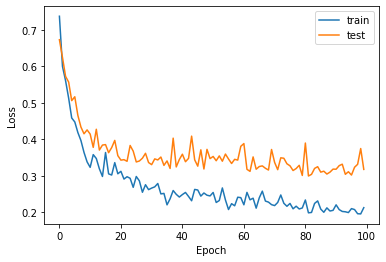

In [256]:
my_nn = DNA_CNN()
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001, weight_decay=1e-2)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

dataset_val = TensorDataset(X_test, y_test)
dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)

losses = []
losses_val = []

epochs = 100 # Number of epochs

for epoch in range(epochs):
    
    avg_train_loss = train(my_nn, optimizer, criterion, dataloader)
    avg_val_loss = test(my_nn, criterion, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)
    
    if epoch in [0, 9, 49, 99]:
        metrics = eval_model(my_nn, dataloader_val)
        print(f"\nEpoch {epoch+1}")
        print("Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Genoma completo

In [2]:
def extract_binding_sequences_center(bed_file, fasta_file, output_fasta, length):

    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    bed = BedTool(bed_file)

    records = []

    for i, interval in enumerate(bed):
        chrom = interval.chrom

        if chrom != "chr22":
            start = int(interval.start)
            end = int(interval.end)
            center = (start + end) // 2
            center_start = center - (length//2)
            center_end = center + (length//2)

            seq = genome[chrom].seq[center_start:center_end] 
            record = SeqRecord(seq, id=f"{chrom}:{center_start}-{center_end}", description="")
            records.append(record.upper())

    SeqIO.write(records, output_fasta, "fasta")

In [5]:
extract_binding_sequences_center("jun_np_GRCh38.bed", "hg38.fa", "jun_np.fasta", 100)